# Copyright
<pre>
Jelen forráskód a Budapesti Műszaki és Gazdaságtudományi Egyetemen tartott
"Deep Learning a gyakorlatban Python és LUA alapon" tantárgy segédanyagaként készült.

A tantárgy honlapja: http://smartlab.tmit.bme.hu/oktatas-deep-learning
Deep Learning kutatás: http://smartlab.tmit.bme.hu/deep-learning

A forráskódot GPLv3 licensz védi. Újrafelhasználás esetén lehetőség szerint kérjük
az alábbi szerzőt értesíteni.

2021 (c) Csapó Tamás Gábor (csapot kukac tmit pont bme pont hu),
Gyires-Tóth Bálint, Zainkó Csaba


Original Variational AutoEncoder example from:

Links:
[Louis Tiao blog] http://louistiao.me/posts/implementing-variational-autoencoders-in-keras-beyond-the-quickstart-tutorial/
[Keras Variational AutoEncoder] https://blog.keras.io/building-autoencoders-in-keras.html
https://raw.githubusercontent.com/fchollet/keras/master/examples/variational_autoencoder.py
[Auto-Encoding Variational Bayes] https://arxiv.org/abs/1312.6114
</pre>

In [1]:
# http://louistiao.me/posts/implementing-variational-autoencoders-in-keras-beyond-the-quickstart-tutorial/

# állítsuk be, hogy TF v1-gyel szeretnénk dolgozni, majd runtime restart
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
import tensorflow
tensorflow.__version__

'1.15.2'

In [3]:
# ezeket érdemes előre feltenni, mert pár percig eltarthat a telepítés (plot_model-hez kell)
!pip install -q pydot
!apt install graphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [4]:
from keras.layers import Input, Dense, Lambda, Layer, Multiply, Add
from keras.models import Model, Sequential
from keras.utils.vis_utils import plot_model
from keras import backend as K
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np

Using TensorFlow backend.


In [5]:
# Variational AutoEncoder-t fogunk készíteni, ami az MNIST digitekhez generál új képeket

batch_size = 100
original_dim = 784 # MNIST képek mérete
latent_dim = 2 # látens dimenzió: 2D
intermediate_dim = 256 # belső 'AutoEncoder' jellegű tömörítés
epochs = 15


In [6]:
# nézd meg a VAE hálózat általános alakját (előadás fólia)

# először egy egyszerű dekóder hálózat

decoder = Sequential([
    Dense(intermediate_dim, input_dim=latent_dim, activation='relu'),
    Dense(original_dim, activation='sigmoid')
])

decoder.summary()


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               768       
_________________________________________________________________
dense_2 (Dense)              (None, 784)               201488    
Total params: 202,256
Trainable params: 202,256
Non-trainable params: 0
_________________________________________________________________


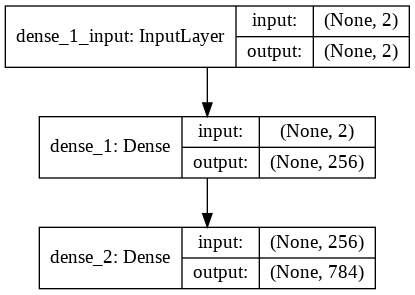

In [7]:
# dekóder modell grafikus kirajzolása
plot_model(decoder, show_shapes=True, show_layer_names=True)

In [8]:
# encoder hálózat (inference)
# nézd meg a VAE hálózat általános alakját (előadás fólia)

# bemeneti réteg
x = Input(shape=(original_dim,))

# rejtett réteg
h = Dense(intermediate_dim, activation='relu')(x)

# kimeneti réteg: átlag és a variancia logaritmusa
z_mu = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

# mivel ennek a hálónak több kimenete van,
# nem tudjuk a keras Sequential APIt használni,
# hanem helyette a Functional API kell
# https://keras.io/getting-started/functional-api-guide/


In [9]:
# nézd meg a VAE hálózat általános alakját és a KL divergencia számítást (előadás fólia)

# a VAE hálózat közepén van egy KL-divergencia számítás,
# amit egyéni réteg megírásával oldunk meg
# a 'KLDivergenceLayer' átmásolható innen:
# https://github.com/BME-SmartLab-Education/vitmav45/blob/master/13/01_VAE_helper.py

class KLDivergenceLayer(Layer):

    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):

        mu, log_var = inputs

        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)

        self.add_loss(K.mean(kl_batch), inputs=inputs)

        return inputs

In [10]:
# az eddigiek összerakása

# korábbi encoder hálózat (inference) -- felülről másolható
# bemeneti réteg
x = Input(shape=(original_dim,))

# rejtett réteg
h = Dense(intermediate_dim, activation='relu')(x)

# kimeneti réteg: átlag és a variancia logaritmusa
z_mu = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)



# nézd meg a VAE hálózat általános alakját (előadás fólia)

# KL-divergencia réteg...
z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])

# 'var': variancia = szórásnégyzet
# log varianciából kiszámítjuk a szórást
z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var)

# normál eloszlású zaj
eps = Input(tensor=K.random_normal(shape=(K.shape(x)[0],
                                          latent_dim)))

# keras Merge rétegek (Multiply, Add) : reparameterization
z_eps = Multiply()([z_sigma, eps])
z = Add()([z_mu, z_eps])



# korábbi dekóder hálózat -- felülről másolható
decoder = Sequential([
    Dense(intermediate_dim, input_dim=latent_dim, activation='relu'),
    Dense(original_dim, activation='sigmoid')
])


# ez itt új rész
x_pred = decoder(z)

In [11]:
# a hibafüggvény most egyéni lesz: negatív log-likelihood

# log_pθ(x|z)
def nll(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """

    # keras.losses.binary_crossentropy gives the mean
    # over the last axis. we require the sum
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

In [12]:
# teljes VAE modell
vae = Model(inputs=[x, eps], outputs=x_pred)
vae.compile(optimizer='rmsprop', loss=nll)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [13]:
vae.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 256)          200960      input_2[0][0]                    
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 2)            514         dense_6[0][0]                    
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 2)            514         dense_6[0][0]                    
____________________________________________________________________________________________

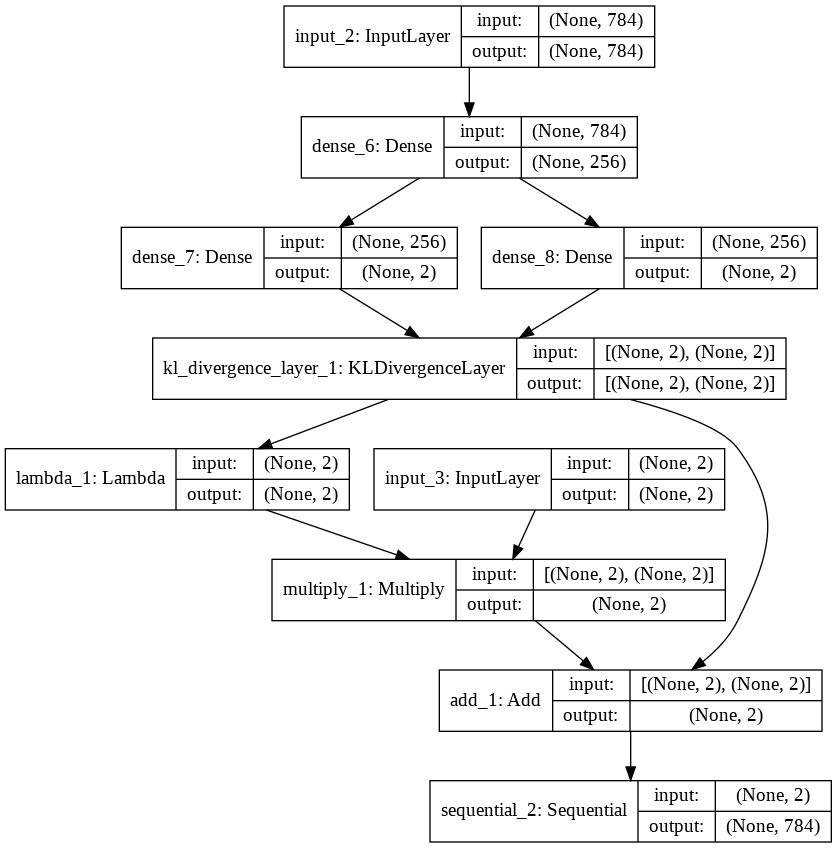

In [14]:
# hasonlítsuk össze a mi hálónkat a VAE általános alakjával,
# (előadás fólia)

plot_model(vae, show_shapes=True, show_layer_names=True)

In [15]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, original_dim) / 255.
x_test = x_test.reshape(-1, original_dim) / 255.

In [16]:
# a VAE-t úgy tanítjuk, hogy a bemenet és kimenet egyezik:
# az input és a target is x_train

vae.fit(x_train,
        x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))


Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 5s 80us/step - loss: 189.7172 - val_loss: 172.2494
Epoch 2/15
60000/60000 [==============================] - 4s 63us/step - loss: 170.1703 - val_loss: 168.2296
Epoch 3/15
60000/60000 [==============================] - 4s 63us/step - loss: 167.0865 - val_loss: 166.2374
Epoch 4/15
60000/60000 [==============================] - 4s 64us/step - loss: 165.1522 - val_loss: 164.6577
Epoch 5/15
60000/60000 [==============================] - 4s 63us/step - loss: 163.4562 - val_loss: 163.2375
Epoch 6/15
60000/60000 [==============================] - 4s 64us/step - loss: 161.7593 - val_loss: 161.2686
Epoch 7/15
60000/60000 [==============================] - 4s 63us/step - loss: 160.2539 - val_loss: 160.1155
Epoch 8/15
60000/60000 [==============================] - 4s 64us/step - loss: 159.0733 - val_loss: 159.1306
Epoch 9/15
60000/60000 [==============================] - 4s 64us/step - loss

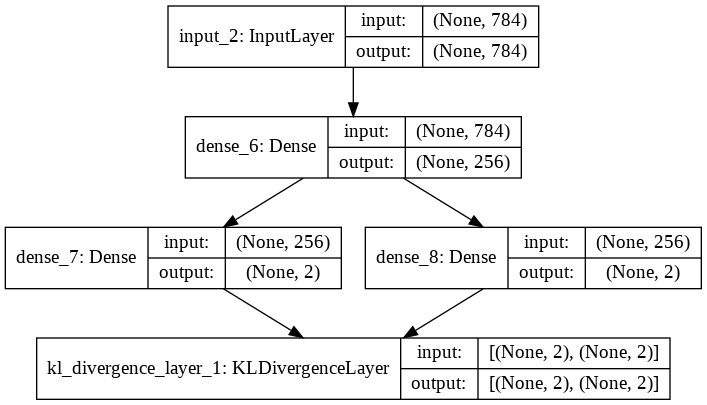

In [17]:
# modell kiértékelése

# enkóder: eredeti képek -> látens tér (2D)
encoder = Model(x, z_mu)

plot_model(encoder, show_shapes=True, show_layer_names=True)

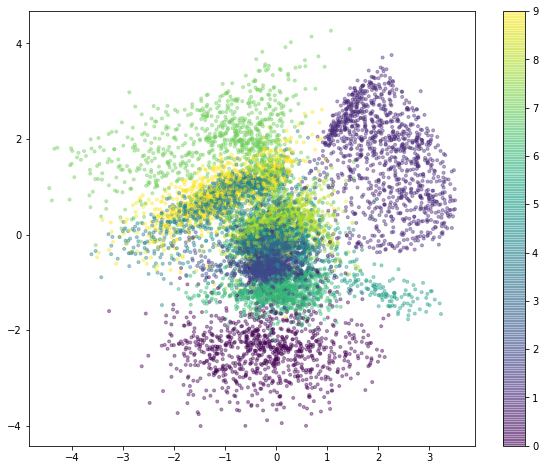

In [18]:
# digit osztályok kirajzolása 2D-ben, a látens térben
# azt érdemes észrevenni, hogy az egyes digitek (különböző színek)
# egész jól elkülönülnek

# enkóder: eredeti képek -> látens tér (2D)

z_test = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(10, 8))
plt.scatter(z_test[:, 0], z_test[:, 1], c=y_test,
            alpha=.4, s=3**2, cmap='viridis')
plt.colorbar()
plt.show()

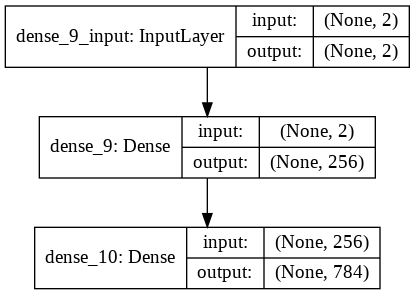

In [19]:
# dekóder újra, emlékeztetőnek
# a 2D látens reprezentációból tud majd új digiteket generálni

plot_model(decoder, show_shapes=True, show_layer_names=True)


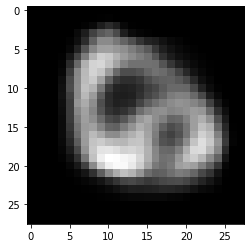

In [23]:
# véletlen képek generálása
# (többször le lehet futtatni, és mutatni jobb / rosszabb példákat)
z_sample = norm.ppf(np.random.rand(1,2))
generated_digit = decoder.predict(z_sample)
plt.imshow(generated_digit.reshape(28,28), cmap='gray')
plt.show()

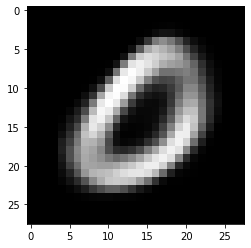

In [24]:
# véletlen képek generálása
# (többször le lehet futtatni, és mutatni jobb / rosszabb példákat)
z_sample = norm.ppf(np.random.rand(1,2))
generated_digit = decoder.predict(z_sample)
plt.imshow(generated_digit.reshape(28,28), cmap='gray')
plt.show()

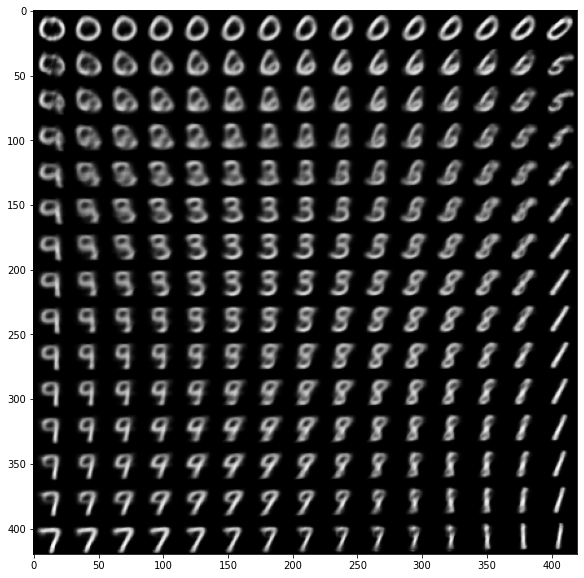

In [25]:
# digitek 2D síkon ábrázolva
n = 15  # 15x15 digit
digit_size = 28

# linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian to produce values
# of the latent variables z, since the prior of the latent space
# is Gaussian

z1 = norm.ppf(np.linspace(0.01, 0.99, n))
z2 = norm.ppf(np.linspace(0.01, 0.99, n))

z_grid = np.dstack(np.meshgrid(z1, z2))

x_pred_grid = decoder.predict(z_grid.reshape(n*n, latent_dim)) \
                     .reshape(n, n, digit_size, digit_size)

plt.figure(figsize=(10, 10))
plt.imshow(np.block(list(map(list, x_pred_grid))), cmap='gray')
plt.show()

In [ ]:
# itt a vége.
# ami tehát összefoglalás: a Variational Autoencoder nevében hasonlít az AutoEncoder hálózatokhoz,
# de valójában itt a lényeg már a generatív modellezés